### Problem Statement

A retail store that has multiple outlets across the country are facing issues in managing the inventory - to match the demand with respect to supply.

Having done the EDA in the previous section of the assignment, predictive modeling techniques to forecast the sales for each store for the next 12 weeks.

**Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error


**Loading the dataset**

In [2]:
# Load the data
data = pd.read_csv('Walmart DataSet.csv')

# General overview of data
data.info()
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


**Data Cleaning and Pre-processing**

In [3]:
# Check for missing values
print(data.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [4]:
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y")

From the EDA done earlier in the assignment, we observed that there were outliers present in 3 of the variables i.e. Weekly_Sales, Temperature and Unemployment. We will treat the outliers by capping them at the upper and lower bounds

In [5]:
# Outlier treatment
# Function to cap outliers using IQR
def cap_outliers(df, column, lower_pct=0.05, upper_pct=0.95):
    # Calculate the IQR (Interquartile Range)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Apply capping to outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])    
    return df

# Apply the capping function to the 'Weekly_Sales' column
data = cap_outliers(data, 'Weekly_Sales')
# Apply the capping function to the 'Temperature' column
data = cap_outliers(data, 'Temperature')
# Apply the capping function to the 'Unemployment' column
data = cap_outliers(data, 'Unemployment')

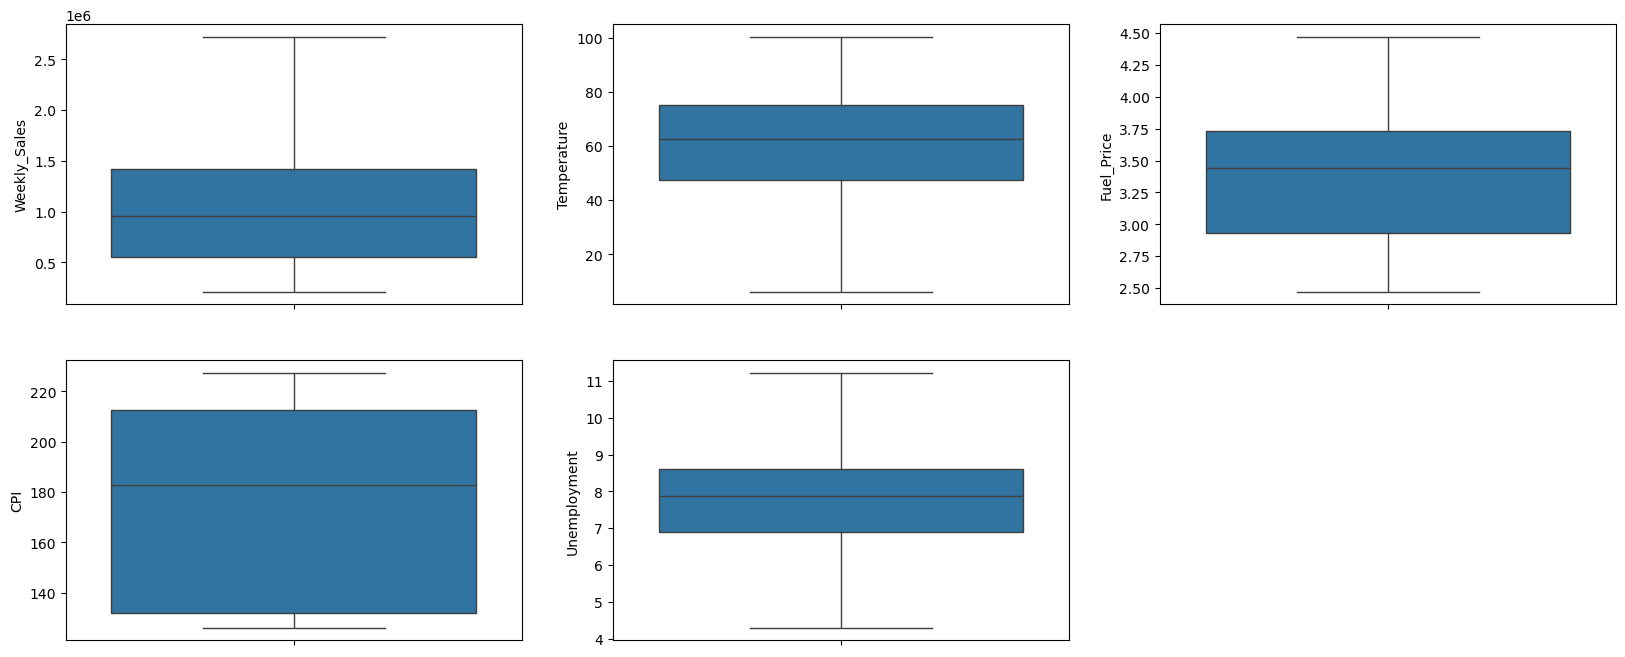

In [6]:
# Check if all outliers are treated
num_var = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]
plt.figure(figsize=(20, 8))
plt.subplot(2,3,1)
sns.boxplot(y = num_var[0], data = data)
plt.subplot(2,3,2)
sns.boxplot(y = num_var[1], data = data)
plt.subplot(2,3,3)
sns.boxplot(y = num_var[2], data = data)
plt.subplot(2,3,4)
sns.boxplot(y = num_var[3], data = data)
plt.subplot(2,3,5)
sns.boxplot(y = num_var[4], data = data)
plt.show()


**Trend and Seasonality Analysis**


Since we have data at a store level, we will firstly roll up all data so that the data is at a Date level. This will allow us to analyze the data from an overall perspective

In [7]:
combined_data = pd.DataFrame(data.groupby('Date')['Weekly_Sales'].sum())
combined_data

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


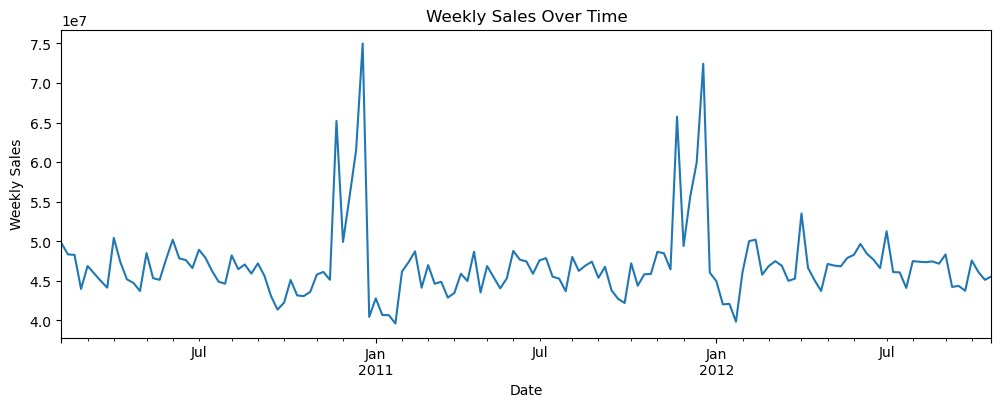

In [8]:
# We will visualize the sales over time to look for any trends and seasonality
plt.figure(figsize=(12, 4))
combined_data['Weekly_Sales'].plot()
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

From the trendline, we can observe that there is a seasonal patter present in the data as the sales peak during the holiday periods, particularly in the month of December.

**Time Series Decomposition**

<Figure size 1200x1500 with 0 Axes>

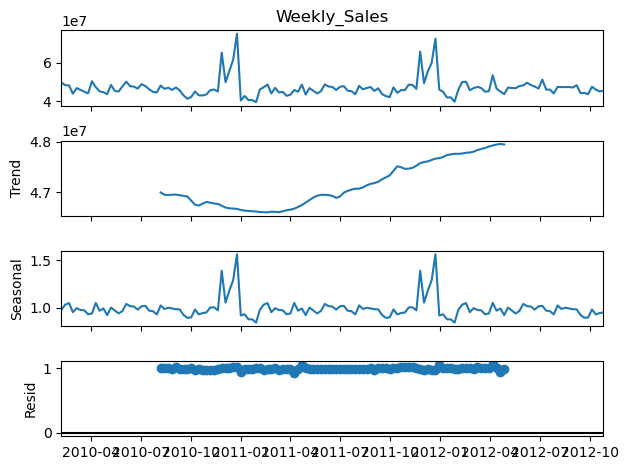

In [9]:
# Decompose the time series data to extract the trend, seasonal, and residual components
decomposition = seasonal_decompose(combined_data['Weekly_Sales'], model='multiplicative', period=52)
plt.figure(figsize=(12, 15))
decomposition.plot()
plt.show()

**Checking for Stationarity**

_ADF(Augmented Dickey Fuller Test)_


In [ ]:
# Perform Dickey-Fuller Test to check if the data is stationary
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The data is stationary")
    else:
        print("The data is not stationary")


In [11]:
# Check stationarity of 'Weekly_Sales'
print("\nADF Test for Weekly Sales:")
adf_test(combined_data['Weekly_Sales'])


ADF Test for Weekly Sales:
ADF Statistic: -6.117153400498526
p-value: 9.036826380340321e-08
The data is stationary


From the Dickey-Fuller test, we can observe that the time series is stationary and we are good to go ahead with building the model

_KPSS_

In [12]:
kpss_test = kpss(combined_data['Weekly_Sales'])
print(kpss_test)

(0.05047163602475032, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\91991\AppData\Local\Temp\ipykernel_22984\2963655928.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(combined_data['Weekly_Sales'])


In [13]:
print('KPSS statistic: %f' % kpss_test[0])
print('Critical Value @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %.2f' % kpss_test[1])

KPSS statistic: 0.050472
Critical Value @ 0.05: 0.46
p-value: 0.10


The p-value for the KPSS is greater than 0.05, hence indicating that the series is stationary

**Autocorrelation Plot(ACF Plot)**

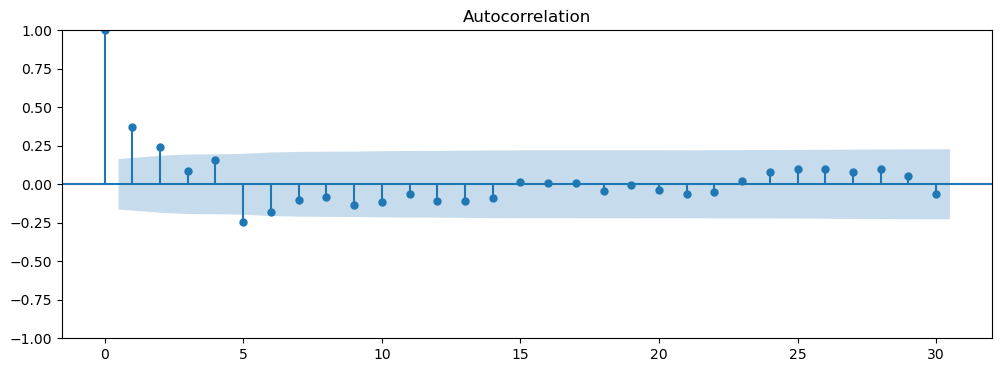

In [14]:
plt.figure(figsize=(12,4))
plot_acf(combined_data['Weekly_Sales'] ,ax=plt.gca(),lags=30)
plt.show()

**Partial Autocorrelation Plot(PACF)**

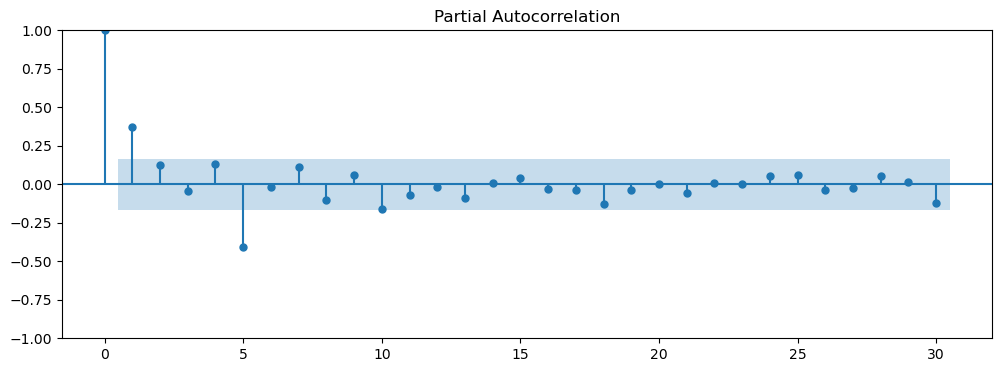

In [15]:
plt.figure(figsize=(12,4))
plot_pacf(combined_data['Weekly_Sales'], ax=plt.gca(),lags=30)
plt.show()

**Building multiple seasonality models to forecast weekly sales**

Splitting the data into train and test, this will allow us to evaluate the model on future data

In [16]:
# Train and test data for this store
train_size = int(0.85 * combined_data.shape[0])
train_data = combined_data.iloc[:train_size]
test_data = combined_data[train_size:]

In [17]:
print(f"Train: {train_data.shape}")
print(f"Test: {test_data.shape}")

Train: (121, 1)
Test: (22, 1)


**1. ARIMA Forecasting**

First, we'll train the ARIMA model on the training data and evaluate it on the test data 

In [19]:
model = ARIMA(train_data, order=(2,1,3), trend='t')
model_fit = model.fit()
print(model_fit.summary())
print("###########################################")
print(model_fit.params)


                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  121
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2027.943
Date:                Tue, 12 Nov 2024   AIC                           4069.887
Time:                        23:47:26   BIC                           4089.399
Sample:                    02-05-2010   HQIC                          4077.811
                         - 05-25-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.549e+04   3.46e+05     -0.045      0.964   -6.94e+05    6.63e+05
ar.L1         -0.9170      0.208     -4.416      0.000      -1.324      -0.510
ar.L2         -0.2933      0.218     -1.346      0.1

c:\Users\91991\anaconda3\envs\pgp-de\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\91991\anaconda3\envs\pgp-de\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\91991\anaconda3\envs\pgp-de\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [20]:
# Generating forecast predictions
y_hat_arima = combined_data.copy()   ##### Forecasting the series which doesn't have differenced term
y_hat_arima['arima_forecast'] = model_fit.predict(combined_data.index.min(), combined_data.index.max())

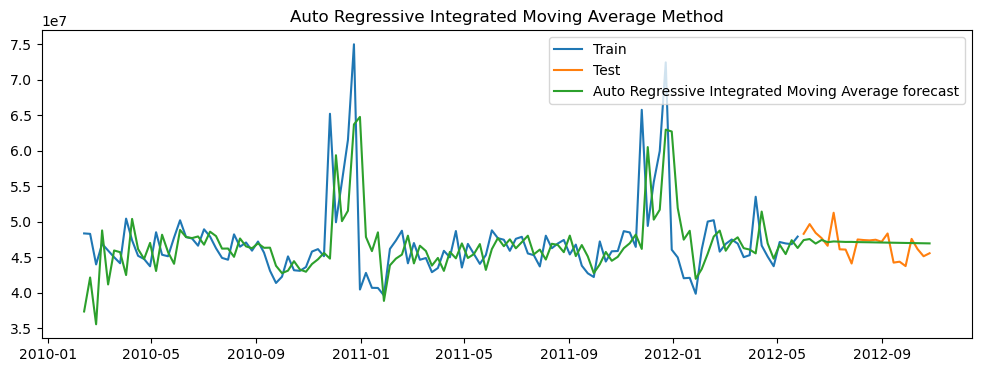

In [21]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Weekly_Sales'][1:], label='Train')
plt.plot(test_data['Weekly_Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][1:], label='Auto Regressive Integrated Moving Average forecast')
plt.legend(loc='best')
plt.title('Auto Regressive Integrated Moving Average Method')
plt.show()

In [22]:
# Evaluating the model performance
rmse = np.sqrt(mean_squared_error(test_data['Weekly_Sales'], y_hat_arima['arima_forecast'][test_data.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_data['Weekly_Sales']-y_hat_arima['arima_forecast'][test_data.index.min():])/test_data['Weekly_Sales'])*100,2)

print(f"RMSE: {round(rmse)}")
print(f"MAPE: {mape}%")


RMSE: 1779794
MAPE: 2.99%


**2. SARIMA Forecasting**

In [23]:
model = SARIMAX(train_data, order=(2,1,3), seasonal_order=(2,1,3,52), trend='t')
model_fit = model.fit()
print(model_fit.summary())
print("###########################################")
print(model_fit.params)


c:\Users\91991\anaconda3\envs\pgp-de\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\91991\anaconda3\envs\pgp-de\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\91991\anaconda3\envs\pgp-de\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  121
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 52)   Log Likelihood               -1084.267
Date:                            Tue, 12 Nov 2024   AIC                           2192.534
Time:                                    23:49:06   BIC                           2219.168
Sample:                                02-05-2010   HQIC                          2203.087
                                     - 05-25-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       4324.1596   3.58e+04      0.121      0.904   -6.59e+04    7.46e+04
ar.L1         -1.5465      0.195   

In [24]:
# Generating forecast predictions
y_hat_sarima = combined_data.copy()   ##### Forecasting the series which doesn't have differenced term
y_hat_sarima['sarima_forecast'] = model_fit.predict(combined_data.index.min(), combined_data.index.max())

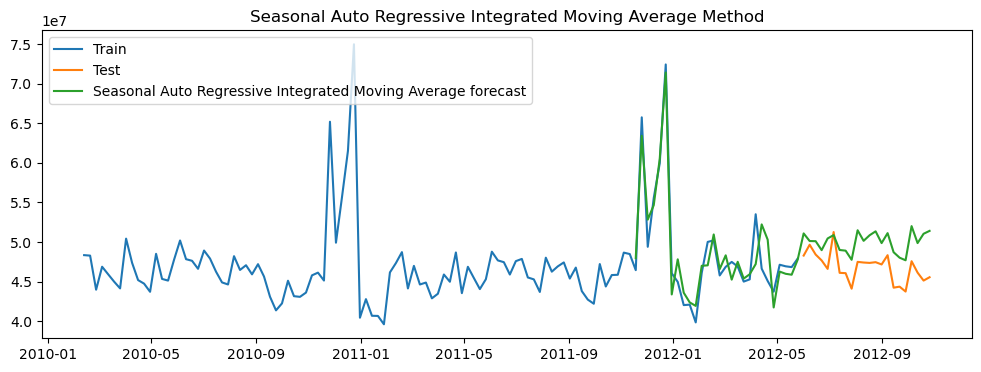

In [25]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Weekly_Sales'][1:], label='Train')
plt.plot(test_data['Weekly_Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][-50:], label='Seasonal Auto Regressive Integrated Moving Average forecast')
plt.legend(loc='best')
plt.title('Seasonal Auto Regressive Integrated Moving Average Method')
plt.show()

In [26]:
# Evaluating the model performance
rmse = np.sqrt(mean_squared_error(test_data['Weekly_Sales'], y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_data['Weekly_Sales']-y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data['Weekly_Sales'])*100,2)

print(f"RMSE: {round(rmse)}")
print(f"MAPE: {mape}%")


RMSE: 3536773
MAPE: 7.03%


**4. SARIMAX Forecasting**

Considering we have 5 other variables along with Weekly Sales in our data, we can use these variables as exogenous variables to help provide more information while training using a SARIMAX model

In [27]:
# Creating the exogenous variable dataset at the same level as the combine weekly sales dataset
combined_data_exog = pd.DataFrame(data.groupby('Date').agg({'Holiday_Flag' : 'max', 
                                                           'Temperature' : 'mean',
                                                           'Fuel_Price' : 'mean', 
                                                           'CPI' : 'mean', 
                                                           'Unemployment' : "mean"}))
combined_data_exog.head()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,
2010-02-05,0,34.037333,2.717844,167.730885,8.435544
2010-02-12,1,34.151333,2.694022,167.825608,8.435544
2010-02-19,0,37.719778,2.672067,167.871686,8.435544
2010-02-26,0,39.243556,2.683933,167.909657,8.435544
2010-03-05,0,42.917333,2.731200,167.947628,8.435544


In [28]:
train_data_exog = combined_data_exog.iloc[:train_size]
test_data_exog = combined_data_exog[train_size:]

print(f"Train: {train_data_exog.shape}")
print(f"Test: {test_data_exog.shape}")

Train: (121, 5)
Test: (22, 5)


In [29]:
# Build and fit the SARIMAX model
model = SARIMAX(train_data['Weekly_Sales'], exog=train_data_exog, order=(2, 1, 3), 
                seasonal_order=(2,1,3,52), trend='t')
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())
print("###########################################")
print(model_fit.params)


c:\Users\91991\anaconda3\envs\pgp-de\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\91991\anaconda3\envs\pgp-de\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\91991\anaconda3\envs\pgp-de\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  121
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 52)   Log Likelihood               -1085.768
Date:                            Tue, 12 Nov 2024   AIC                           2205.536
Time:                                    23:51:20   BIC                           2243.267
Sample:                                02-05-2010   HQIC                          2220.486
                                     - 05-25-2012                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
drift         7942.4604   4.05e+04      0.196      0.845   -7.15e+04    8.74e+04
Holiday_Flag   7.81e-07    11

In [30]:
# Generating forecast predictions
y_hat_sarimax = combined_data.copy()
y_hat_sarimax['sarimax_forecast'] = model_fit.predict(start=test_data.index.min(), 
                                                       end=test_data.index.max(), 
                                                       exog=test_data_exog)


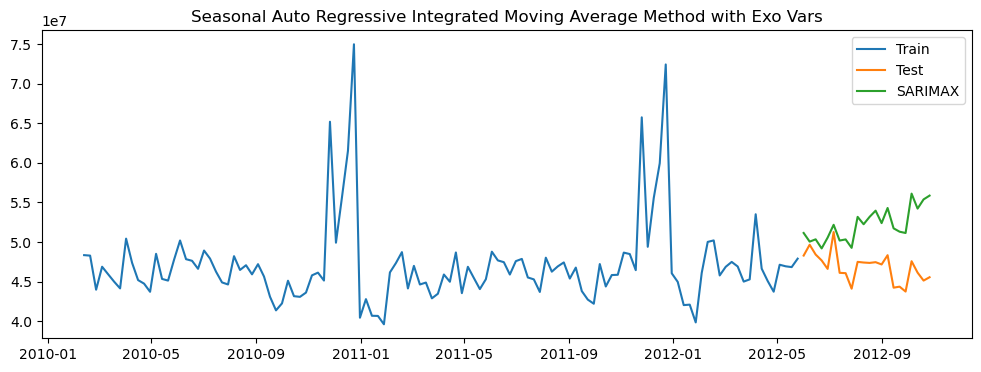

In [31]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Weekly_Sales'][1:], label='Train')
plt.plot(test_data['Weekly_Sales'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][-50:], label='SARIMAX')
plt.legend(loc='best')
plt.title('Seasonal Auto Regressive Integrated Moving Average Method with Exo Vars')
plt.show()

In [32]:
# Evaluating the model performance
rmse = np.sqrt(mean_squared_error(test_data['Weekly_Sales'], y_hat_sarimax['sarimax_forecast'][test_data.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_data['Weekly_Sales']-y_hat_sarimax['sarimax_forecast'][test_data.index.min():])/test_data['Weekly_Sales'])*100,2)

print(f"RMSE: {round(rmse)}")
print(f"MAPE: {mape}%")


RMSE: 6016353
MAPE: 11.63%


Having evaluated 3 different models, we see that the ARIMA model was the best perfomring model in terms of Mean Absolute Percentage Error.

However, the trends in movement in the forecasts seem to be better explained by the SARIMA model.

As a result, we will use the SARIMA model to build individual forecast models for all the stores

**Forecasts for Individual Stores**

In [36]:
# Getting list of all stores
stores = list(data['Store'].unique())

# Prepare an empty DataFrame to store forecast results
forecast_results = pd.DataFrame()

# Loop over each store to fit and forecast ARIMA
for store in stores:
    # Filter the data for the current store
    store_data = data[data['Store'] == store]

    # Set the date column as index
    store_data.set_index('Date', inplace=True)

    # Use the Weekly_Sales column only since we are implementing ARIMA
    endog = store_data['Weekly_Sales']

    with warnings.catch_warnings():
        warnings.simplefilter('ignore') # Hiding all warnings that may come up during model training
        # Fit the ARIMA model (you can adjust the p, d, q parameters as necessary)
        model = SARIMAX(endog, order=(2, 1, 3), seasonal_order=(2,1,3,52))  # Example parameters, change as needed
        model_fit = model.fit()

    # Generating forecast predictions for next 12 weeks
    forecast_steps = 12  # Number of periods to forecast
    forecast = model_fit.forecast(steps=forecast_steps)

    # Store the forecast results in the forecast_results DataFrame
    forecast_index = pd.date_range(start=store_data.index[-1] + pd.Timedelta(weeks=1), 
                                   periods=forecast_steps, 
                                   freq='W')

    store_forecast = pd.DataFrame(forecast)
    store_forecast.columns= [f'Forecast_Store_{store}']
    
    # Append to the forecast_results DataFrame
    forecast_results = pd.concat([forecast_results, store_forecast], axis=1)

    print(f"Forecasting for store {store} completed...")

# Display the combined forecast results
print("Forecast Results for all Stores saved in forecast_results dataframe.")



Forecasting for store 1 completed...
Forecasting for store 2 completed...
Forecasting for store 3 completed...
Forecasting for store 4 completed...
Forecasting for store 5 completed...
Forecasting for store 6 completed...
Forecasting for store 7 completed...
Forecasting for store 8 completed...
Forecasting for store 9 completed...
Forecasting for store 10 completed...
Forecasting for store 11 completed...
Forecasting for store 12 completed...
Forecasting for store 13 completed...
Forecasting for store 14 completed...
Forecasting for store 15 completed...
Forecasting for store 16 completed...
Forecasting for store 17 completed...
Forecasting for store 18 completed...
Forecasting for store 19 completed...
Forecasting for store 20 completed...
Forecasting for store 21 completed...
Forecasting for store 22 completed...
Forecasting for store 23 completed...
Forecasting for store 24 completed...
Forecasting for store 25 completed...
Forecasting for store 26 completed...
Forecasting for store

In [43]:
forecast_results.head()

,Forecast_Store_1,Forecast_Store_2,Forecast_Store_3,Forecast_Store_4,Forecast_Store_5,Forecast_Store_6,Forecast_Store_7,Forecast_Store_8,Forecast_Store_9,Forecast_Store_10,...,Forecast_Store_36,Forecast_Store_37,Forecast_Store_38,Forecast_Store_39,Forecast_Store_40,Forecast_Store_41,Forecast_Store_42,Forecast_Store_43,Forecast_Store_44,Forecast_Store_45
2012-11-02,1.711799e+06,2.010738e+06,460211.436265,2.205326e+06,358307.570933,1.516440e+06,538698.187211,9.557187e+05,601337.676051,1.844975e+06,...,274713.708750,552188.572354,466638.922336,1.661531e+06,9.912707e+05,1.363282e+06,586048.290749,632098.372583,345274.562968,7.871565e+05
2012-11-09,1.620868e+06,1.952963e+06,425601.931815,2.166540e+06,328090.795410,1.503864e+06,524750.440582,9.270277e+05,593873.900272,1.978596e+06,...,288315.772210,530234.408830,465841.689685,1.559431e+06,1.002231e+06,1.351647e+06,647388.551961,614983.468302,360470.327295,7.709260e+05
2012-11-16,1.576180e+06,1.968549e+06,417410.289467,2.183988e+06,323846.802403,1.495644e+06,508274.567983,9.077844e+05,544190.825744,1.824339e+06,...,292771.886761,535767.495606,438496.311074,1.613339e+06,8.929550e+05,1.291982e+06,583795.127189,627551.924761,347414.352221,7.451418e+05
2012-11-23,2.014698e+06,2.532755e+06,536378.120565,2.494467e+06,468404.420667,2.106218e+06,902509.704662,1.181247e+06,786751.624496,2.487102e+06,...,286167.662451,542621.670521,421305.168627,2.276982e+06,1.173798e+06,1.825888e+06,561436.084478,653083.365146,358904.693718,1.035185e+06
2012-11-30,1.618342e+06,2.014308e+06,473908.706740,2.144167e+06,372919.893535,1.652761e+06,553191.502675,9.831460e+05,606301.506177,1.978924e+06,...,265590.271540,533755.053729,442827.841180,1.704569e+06,1.029469e+06,1.341066e+06,515951.061862,593583.278338,333810.828666,8.224283e+05


Having created individual models for each store, we can now visualize the forecasted sales for each store for the next 52 weeks.

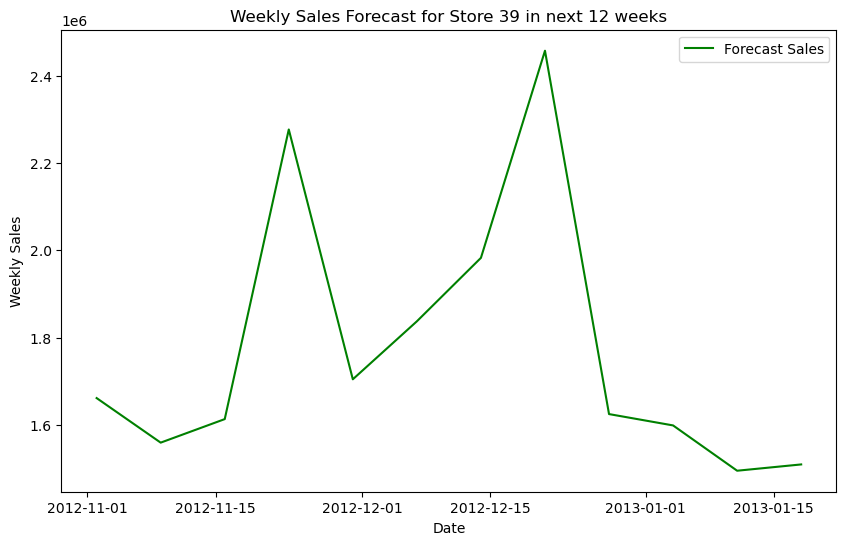

In [40]:
# Visualizing the forecasts for the next 12 weeks for individual stores

store = int(input("Enter store number to see next 12w forecasts: "))

# Plot the actual vs forecasted values for each store
plt.figure(figsize=(10, 6))
plt.plot(forecast_results.index, forecast_results[f'Forecast_Store_{store}'], label='Forecast Sales', color = 'green')
plt.title(f'Weekly Sales Forecast for Store {store} in next 12 weeks')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


**Summary of Time Series Forecasting Project**

In this project, we aimed to forecast weekly sales data for multiple retail stores using various time series forecasting models. The main steps included:

**Data Preparation:**

Data was cleaned and preprocessed, including handling missing values and detecting outliers. Exogenous variables such as Temperature, Fuel Price, CPI, and Unemployment were considered for models like SARIMAX.

**Exploratory Data Analysis (EDA):**

- Outlier detection and capping were performed to avoid model distortion.
- Statistical relationships between variables (such as temperature, CPI, and unemployment) and sales were analyzed.

**Forecasting Models:**

- ARIMA was used for initial forecasting
- SARIMA was used to factor in seasonality
- SARIMAX was used to incorporate exogenous variables along with the time series patterns

_Eventually, we built SARIMA models for each of the 45 stores to forecast the sales for the next 12 weeks as per the problem statement._

**Results:**

- For each store, forecasts were generated for the next 12 weeks.
- Forecasts were compared with actual sales to assess model performance.
- Visualizations were created for actual vs. forecasted sales to gain insights into model accuracy.
